> ### EEE4423: Deep Learning Lab

# LAB \#12: Sequence to Sequence Network with Attention Module
## Machine Translation with Attention

<h4><div style="text-align: right"> Due date: May 27, 2022. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab12.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2018142102] [Euijin Hong]</span> </h2>

In [33]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-25 14:57:20.766102


In this project we will be teaching a neural network to translate from
French to English.
*************************************************************
::

    [(>): input, (=): target, (<): output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

...
*************************************************************

In [34]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Prepare data

The data for this project is a set of many thousands of English to French translation pairs. Download the data from <https://download.pytorch.org/tutorial/data.zip>. The file is a tab separated list of translation pairs:


    I am cold.    J'ai froid.
    
<img src="https://drive.google.com/uc?export=view&id=1K3W2RxeTKih5IiT5PcIyWNZSwMqtYSGZ"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

In [35]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10 # limit the sentence length
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

class Lang: # mapping to numbers for each language, frn and eng respectively
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('./dataset-dllab/lab12/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", input_lang.name, '=', input_lang.n_words, output_lang.name, '=', output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counted words: fra = 4345 eng = 2803
['tu me fais marrer .', 'you re amusing .']


In [36]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 2. Build the Seq2Seq model [5 points]

<img src="https://drive.google.com/uc?export=view&id=1kKXrIIxi0t-Nm5HfzOukqjzEp7yEXEpV"  onerror="this.style.display='none'" /><br><br>

[sequence to sequence network](https://arxiv.org/abs/1409.3215) is a model in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a single vector,
and a decoder network unfolds that vector into a new sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

#### Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.  
<img src="https://drive.google.com/uc?export=view&id=1PyKBEVl5jwQfB0I0P2kG8nTGQVZQdZEM"  onerror="this.style.display='none'" /><br><br>

#### GRU
<img src="https://drive.google.com/uc?export=view&id=1467jVFRYbw1DYvVKeSyzGWLRmtlqpy8z"  onerror="this.style.display='none'" style="width: 700px;"/><br><br>
The GRU operates using a reset gate (r) and an update gate (z). The candidate state is created by using the previous hidden state and the current input. It is the reset gate that determines how the previous hidden state affects the candidate state. The newly created candidate state and the previous hidden state create a new hidden state, in which the update gate plays a role in balancing the two.

#### LSTM vs GRU
<img src="https://drive.google.com/uc?export=view&id=1lzGTsIYvPWKNF-XaTevMaaZvjfgp9G35"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

| <center>LSTM</center> | <center>GRU</center>  |
|:--------|--------|
| LSTM has 3 gates (forget, input, output) | GRU has 2 gates (reset, update) |
| There is an internal memory (cell state) | There is no cell state and only hidden state exists |
| When making output, another non-linearity is applied | There is no additional non-linearity when making output  |

In [37]:
# 2 points
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        
        self.input_dim = input_dim
        
        self.hidden_dim = hidden_dim
        
        # layer_dim과 batch_size는 1로 설정
        self.layer_dim = 1
        self.batch_size = 1

        self.embedding = nn.Embedding(input_dim, hidden_dim)

        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        # initialize the linear layers and sigmoid function
        self.sigmoid = nn.Sigmoid()
        
        self.update_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.update_layer_h = nn.Linear(hidden_dim, hidden_dim)
        
        self.reset_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.reset_layer_h = nn.Linear(hidden_dim, hidden_dim)
        
        self.candidate_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.candidate_layer_h = nn.Linear(hidden_dim, hidden_dim)
        #############

    def forward(self, input, hn):
        #############
        # set h_(n-1) and x_n from the given input and hn values
        hn_1 = hn
        xn = self.embedding(input)
        
        # calculate z(update gate), r(reset gate), and candidate hidden state of current time step
        zn = self.sigmoid(self.update_layer_x(xn[:,0,:]) + self.update_layer_h(hn_1[0,:,:]))
        rn = self.sigmoid(self.reset_layer_x(xn[:,0,:]) + self.reset_layer_h(hn_1[0,:,:]))
        hcn = torch.tanh(self.candidate_layer_x(xn[:,0,:]) + self.candidate_layer_h(hn_1[0,:,:]) * rn)
        
        # calculate the hidden state and output of the current time step
        hn = ((1 - zn) * hcn + zn * hn_1[0,:,:]).unsqueeze(0)
        output = hn
        #############
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # initialize the hidden state to zero-tensor with given dimension
        if torch.cuda.is_available():  # if environment supports GPU
            h0 = torch.autograd.Variable(torch.zeros(self.layer_dim, self.batch_size, self.hidden_dim)).cuda()
        else:  # if environment does not support GPU
            h0 = torch.autograd.Variable(torch.zeros(self.layer_dim, self.batch_size, self.hidden_dim))
        #############
        return h0
    
hidden_dim = 256
encoder = EncoderRNN(input_lang.n_words, hidden_dim).to(device)

#### Decoder
<img src="https://drive.google.com/uc?export=view&id=1Rm_LlpEolCvPuzPWEFOZ-zdTfsgMbtu-"  onerror="this.style.display='none'" /><br><br>

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. Attention allows the decoder network to "focus" on a specific part of
the encoder's outputs for every step and thus help the decoder choose the right output words. 

<img src="https://drive.google.com/uc?export=view&id=18hsS8PAA7I3QaN9oOebfnMGAMhR-6EID"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

<img src="https://drive.google.com/uc?export=view&id=1F1Y92uLvGaI6s-ygyNKNox4ZGiZmTZ3g"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

The attention weights are calculated using an another feed-forward layer which inputs the decoder's input and hidden state. And the calculated attention weight is multiplied to the corresponding hidden state of the encoder, respectively. Note that to actually create and train this layer we have to choose a maximum sentence length. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<img src="https://drive.google.com/uc?export=view&id=1JEE23gtJf4XciJUXLt2R9lZtpRn8mYCN"  onerror="this.style.display='none'" /><br><br>

In [38]:
# 3 points
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p
        
        # 
        self.layer_dim = 1
        self.batch_size = 1

        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        # attention
        # Note that the column of the attention weights is MAX_LENGTH
        # Note that concatenation is used when "attn" and "attn_combine" are created
        #############
        # initialize the linear layers, softmax and ReLU function
        # set the input size to hidden_dim * 2 considering concatenation
        self.attn = nn.Linear(hidden_dim*2, MAX_LENGTH)  
        self.attn_combine = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        #############
        
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        # initialize the linear layers and sigmoid function
        self.sigmoid = nn.Sigmoid()
        
        self.update_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.update_layer_h = nn.Linear(hidden_dim, hidden_dim)
        
        self.reset_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.reset_layer_h = nn.Linear(hidden_dim, hidden_dim)
        
        self.candidate_layer_x = nn.Linear(hidden_dim, hidden_dim)
        self.candidate_layer_h = nn.Linear(hidden_dim, hidden_dim)
        #############
        
        self.out = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input, hn, encoder_outputs):
        input = self.embedding(input).view(1, 1, -1)
        input = self.dropout(input)
        
        # attention
        # All specifications of the operations are described in the above figure (e.g. use ReLU)
        # bmm is a operation which performs a batch matrix-matrix product
        #############
        # set h_(n-1) and x_n from the given input and hn values
        hn_1 = hn
        xn = input
        
        # set the attention input by concatenating the previous hidden state and the embedded input
#         attn_weights = F.softmax(self.attn(torch.cat((input[0], hn_1[0]), 1)), dim=1)
#         attn_input = torch.cat((hn_1, xn), dim=2)
        attn_input = torch.cat((xn[0], hn_1[0]), 1)
        # propagate to the attention linear layer and obtain attention weights by applying softmax
        attn = self.attn(attn_input)
        attn_weights = self.softmax(attn)
        
        # calculate attn_applied by batch matrix multiplication between attention weights and encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        # set the attention combine input by concatenating the attn_applied value and the transformed input
        attn_combine_input = torch.cat((xn[0], attn_applied[0]), 1)
        # propagate to the attention combine linear layer
        attn_combined = self.attn_combine(attn_combine_input).unsqueeze(0)
        # propagate to the ReLU function and obtain the attention output
        attn_output = self.relu(attn_combined)
        #############
        
        # gru
        #############
        # calculate z(update gate), r(reset gate), and candidate hidden state of current time step
        zn = self.sigmoid(self.update_layer_x(attn_output[:,0,:]) + self.update_layer_h(hn_1[0,:,:]))
        rn = self.sigmoid(self.reset_layer_x(attn_output[:,0,:]) + self.reset_layer_h(hn_1[0,:,:]))
        hcn = torch.tanh(self.candidate_layer_x(attn_output[:,0,:]) + self.candidate_layer_h(hn_1[0,:,:]) * rn)
        
        # calculate the hidden state and output of the current time step
        hn = ((1 - zn) * hcn + zn * hn_1[0,:,:]).unsqueeze(0)
        output = hn
        #############
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # initialize the hidden state to zero-tensor with given dimension
        if torch.cuda.is_available():  # if environment supports GPU
            h0 = torch.autograd.Variable(torch.zeros(self.layer_dim, self.batch_size, self.hidden_dim)).cuda()
        else:  # if environment does not support GPU
            h0 = torch.autograd.Variable(torch.zeros(self.layer_dim, self.batch_size, self.hidden_dim))
        #############
        return h0
    
decoder = AttnDecoderRNN(hidden_dim, output_lang.n_words, dropout_p=0.1).to(device)
print(output_lang.n_words)

2803


### 3. Loss function and optimizer

In [39]:
criterion = nn.NLLLoss()

learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

### 4. Write the evaluation code [2 points]

- Using the trained model, display the translated output given input sentence.
- max len < translated output길이 이면 강제로 중단, decoder가 EOS를 예측하면 문장 생성 종료

In [40]:
output_lang.index2word[4]

'.'

In [41]:
def evaluate(sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #############
        # initialize the hidden state of encoder and decoder
        en_hn = encoder.initHidden()
        de_hn = decoder.initHidden()
        #############
        
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoded_words = []
        
        #############
        # propagate every input word and hidden state to the encoder and obtain encoder outputs
        for i in range(input_length):
            en_output, en_hn = encoder(input_tensor[i].unsqueeze(0).cuda(), en_hn)
            encoder_outputs[i] = en_output[0]
        # propagate the encoder output and the hidden state to the decoder and obtain the translated output
        while True:
            # break the loop when length of decoded words exceeds the max length
            if len(decoded_words) > MAX_LENGTH:
                break
            decoder_output, de_hn = decoder(decoder_input, de_hn, encoder_outputs)
            # break the loop when "EOS" is predicted as an output character of current time step
            if decoder_output[0].argmax().item() == 1:
                break
            # concatenate the predicted word to the output string and reset the decoder input based on current decoder output
            else:
                decoded_words.append(output_lang.index2word[decoder_output[0].argmax().item()])
                decoder_input = decoder_output.argmax().unsqueeze(0)
        #############

        return decoded_words
    
def evaluateRandomly():
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

### 5 . Write the code to train the model [3 points]

- During training, use the `Teacher forcing` concept in addition to a naive approach.
    - In other words, instead of using the decoder's guess as the next input, the real target outputs are also used sometimes. This shows faster convergence.
- Plot the training loss curve.
- Show the result using $evaluateRandomly()$ function. Below is an example.
*************************************************************
    > il est en train de peindre un tableau . (input)
    = he is painting a picture . (target)
    < he is painting a picture . (output)
*************************************************************

************************* iter1000 *************************
loss 11.0851
> c est un acteur .
= he is an actor .
< you re very .

************************* iter2000 *************************
loss 19.2924
> il s affaire aux preparatifs du voyage .
= he is busy preparing for the trip .
< he is a good .

************************* iter3000 *************************
loss 27.7523
> je suis remue .
= i m shaken .
< i m a .

************************* iter4000 *************************
loss 20.0283
> tu souffres n est ce pas ?
= you re in pain aren t you ?
< you re not as as as as as as as as

************************* iter5000 *************************
loss 31.6984
> vous etes tres curieux .
= you re very curious .
< you re very brave .

************************* iter6000 *************************
loss 13.1687
> vous etes sympa .
= you re nice .
< you re a .

************************* iter7000 *************************
loss 10.0751
> je suis votre s ur .
= i m your sister .
< i m going to do t

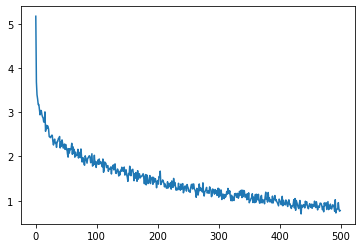

In [42]:
n_iters = 50000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    #############
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #############
    
    # Forward pass
    loss = 0
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    #############
    # initialize the hidden state of encoder and decoder
    en_hn = encoder.initHidden()
    de_hn = decoder.initHidden()
    #############
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
    
    #############
    # forward each word of the input and the previous hidden state to the encoder and obtain the encoder outputs
    for i in range(input_length):
        en_output, en_hn = encoder(input_tensor[i].unsqueeze(0), en_hn)
        encoder_outputs[i] = en_output[0]
    #############
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    #############
    # forward each input word, previous hidden state, and the encoder outputs to the decoder and obtain decoder outputs
    decoder_output = torch.tensor([], device=device).squeeze()
    for i in range(target_length):
        decoder_output, de_hn = decoder(decoder_input, de_hn, encoder_outputs)
        decoder_input = target_tensor[i]
        loss += criterion(decoder_output, target_tensor[i].to(device))
    #############

    # Backward pass
    #############
    loss.backward()
    #############

    # Updating parameters
    #############
    encoder_optimizer.step()
    decoder_optimizer.step()
    #############
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length
    
    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)

In [43]:
evaluateRandomly()

> il est joueur .
= he s a gambler .
< he is a gambler .



In [49]:
evaluateRandomly()

> tu es un etudiant .
= you are a student .
< you are a student .



In [46]:
evaluateRandomly()

> je suis chez moi tom .
= i m home tom .
< i am home tom .



In [47]:
evaluateRandomly()

> tu es le dernier espoir de l humanite .
= you re the last hope for humanity .
< you re the last hope for humanity .



# Discussion
- loss값을 100번의 iteration마다 구한 평균 loss를 plot한 결과, 첫 epoch부터 10000 epoch까지 빠르게 감소하고, 이후 1.0 정도의 값에서 수렴함을 확인할 수 있었습니다. 이를 통해 attention seq2seq network가 epoch가 경과함에 따라 loss의 수렴이 이뤄지며 제대로 학습되고 있다는 것을 알 수 있습니다. 
- Attention 기법을 사용한 seq2seq network는 문장 sequence 내의 단어 별 encoder output에 대해 attention 가중치를 두어, 각각의 decoder hidden state에 attention weight을 반영하여 decoder의 output 계산에 반영합니다. 따라서 seq2seq network는 attention을 통해 문장 내 단어와 단어 사이의 관계를 더욱 잘 파악하며 학습하고, 그에 따라 번역된 문장을 더욱 잘 구성함을 확인할 수 있었습니다. 
- 한편, 1000 epoch마다 print된 번역 결과를 살펴보자면 epoch를 거듭할수록 생성되는 문장이 점차 target sentence와 일치하는 결과를 생성함을 확인할 수 있었습니다. 간혹 loss값이 크게 나타나거나 예측한 translated output이 부정확한 경우도 발생했지만, 그런 경우들 중 의미상으로 비슷한 문장들이 얻어지는 것을 특정 결과값들에서 확인할 수 있었습니다. 더 정확한 예측 결과를 얻기 위해서는 multi-layered seq2seq를 사용하여 layer와 parameter수를 늘리거나, training batch size를 늘려 효율적인 학습이 가능하도록 하는 방식 등을 활용할 수 있을 것입니다. 
- 학습이 완료된 모델에 대해 evaluateRandomly 함수를 실행하여 target sentence와 translated output이 거의 일치함을 확인할 수 있었습니다.다. 앞서 문자열 가공 과정에서 단축어를 설정해 주었기 때문에 사실상 첫 번째와 세번째 결과도 같은 문장을 의미합니다. 이를 통해 현재 학습된 모델은 제공된 데이터셋 내에서 임의로 생성된 프랑스어 문장에 대하여 높은 수준의 정확도를 가지고 영어로 번역된 문장을 만들어낸다는 사실을 알 수 있습니다. 

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)